This notebook demonstrates how to compute the auto power spectra and the cross power spectra for cosmic fields. Here, we use the CMB lensing signal and the CIB temperature.

In [15]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants as scc

from quickspec import lens
from quickspec.cib import hall
from quickspec import cosmo, mps

In [3]:
plt.style.use('ggplot')

# Cosmology

We begin by defining the initial conditions and the cosmology.

In [4]:
initial_cond = mps.mps.initial_ps()

In [5]:
mycosmo = cosmo.lcdm()

In [6]:
vars(mycosmo).keys()

dict_keys(['omr', 'omb', 'omc', 'oml', 'H0', 'h', 'omm', 'zvec', 'xvec', 'zmin', 'zmax', 'xmin', 'xmax', 'spl_x_z', 'spl_z_x'])

# Matter power spectrum

In [7]:
mymps = mps.lin.mps_camb(cosmo=mycosmo, sips=initial_cond, nonlinear=True)

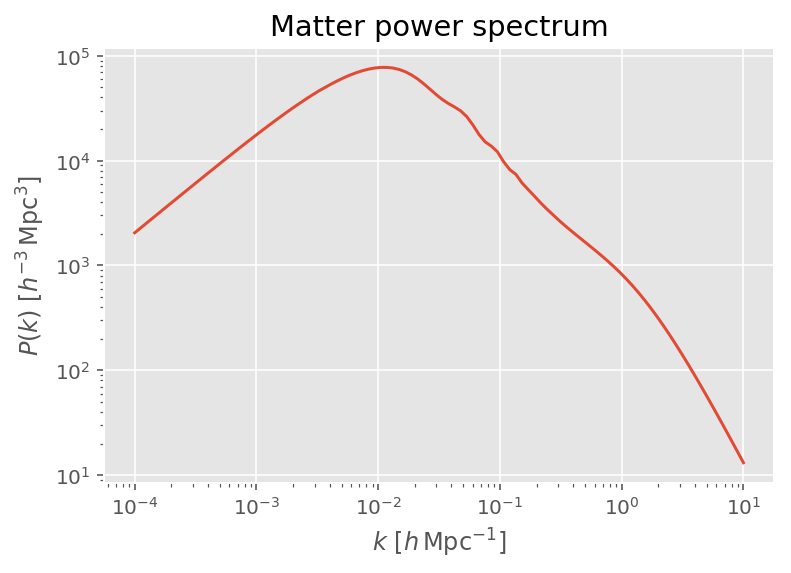

In [8]:
kk = np.logspace(-4, 1, 100)

plt.plot(kk, mymps.p_kz(kk, z=0))
plt.loglog()

# labels & legends
plt.title('Matter power spectrum')
plt.xlabel(r'$k\ [h\,\rm Mpc^{-1}]$')
plt.ylabel(r'$P(k)\ [h^{-3}\,\rm Mpc^3]$');

# Kernels

In [9]:
ls = np.arange(10, 2048., 20)

The lensing kernel used here depends only on `quickspec.cosmo`.

In [10]:
kernel_lens = lens.kern(mycosmo)

For the CIB kernel, we need the FIR frequency at which we want to evaluate the power spectrum and the parameters for the Hall+ (2010) model.

In [16]:
nu = 545.e9
zc = 2.
sigmaz = 2.
b = 0.8 / np.sqrt(2.4)

kernel_cib = hall.ssed_kern(
    nu,
    jbar_kwargs={'zc': zc, 'sigmaz': sigmaz},
    b0=b)

We obtain the powerspectra through calls to `mps.cl_limber_z()`.

In [17]:
# CIBxCMB lensing
powspec_TP = mymps.cl_limber_z(
    kernel_cib, kernel_lens,
    ls=ls, zmin=1.e-2, zmax=20.)

# CIBxCIB lensing
powspec_TT = mymps.cl_limber_z(
    kernel_cib, kernel_cib,
    ls=ls, zmin=1.e-2, zmax=20.)

# CMB lensing x CMB lensing
powspec_PP = mymps.cl_limber_z(
    kernel_lens, kernel_lens,
    ls=ls, zmin=1.e-2, zmax=20.)

## Inspect power spectra

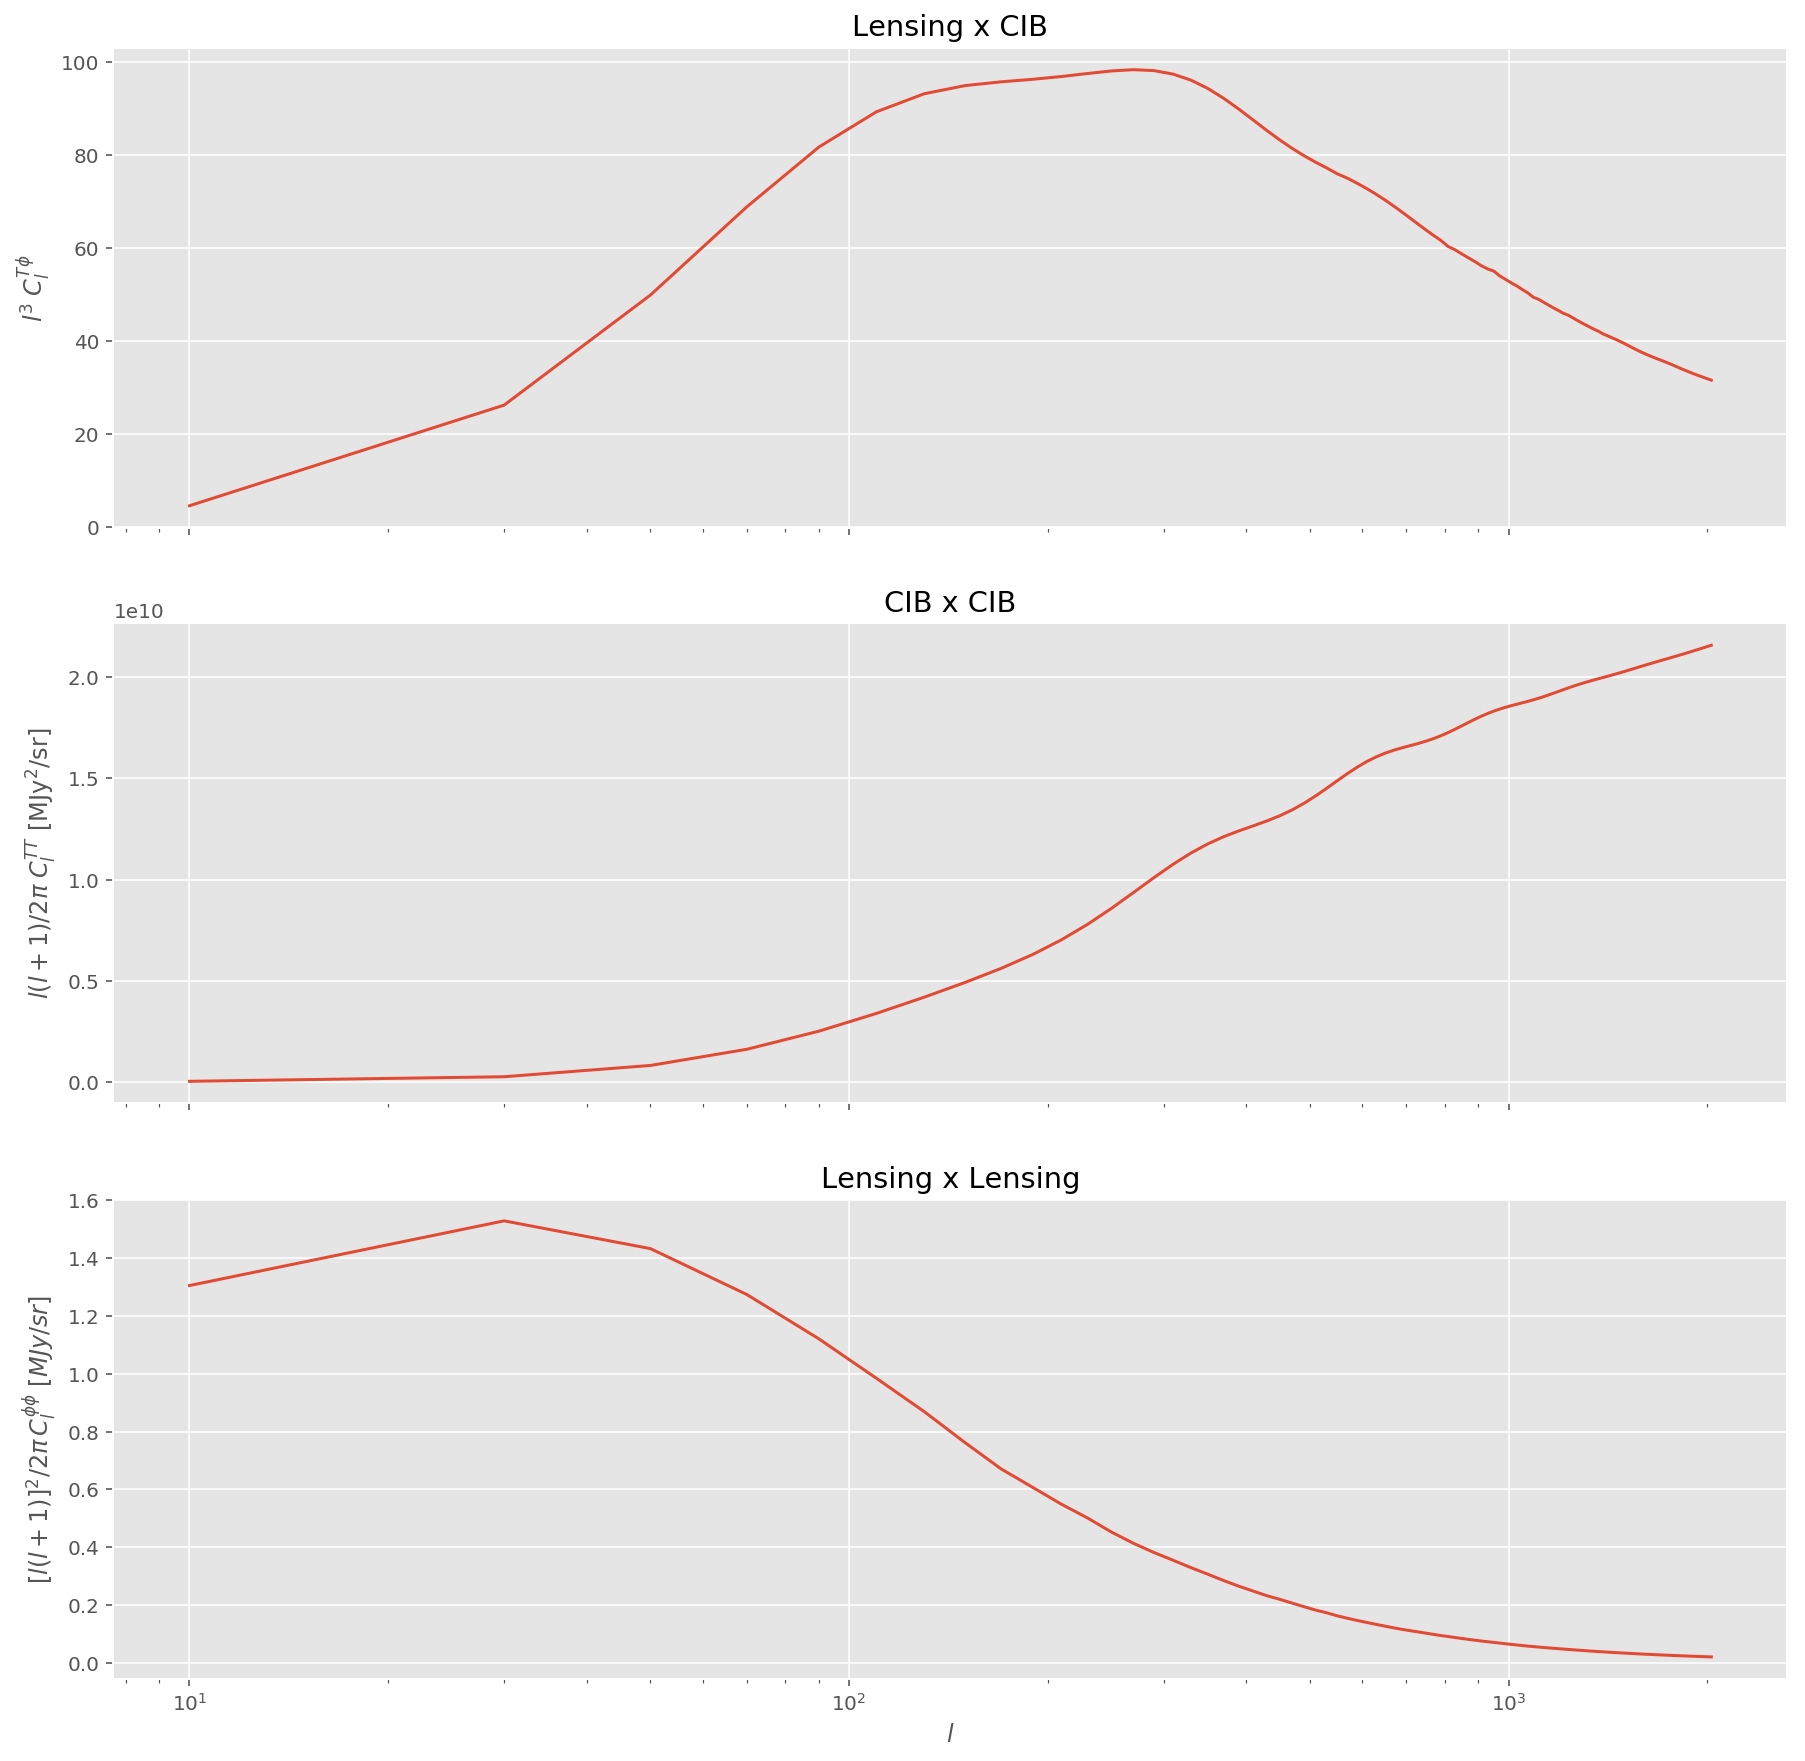

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 15), nrows=3)

# TP
ax1.plot(ls, ls**3 * powspec_TP)
ax1.semilogx()
ax1.xaxis.set_ticklabels([])
ax1.set_ylabel(r'$l^3\; C_l^{T\phi}$')
ax1.set_title('Lensing x CIB')

# TT
ax2.plot(ls, ls * (ls + 1.) / 2. / np.pi * powspec_TT)
ax2.semilogx()
ax2.xaxis.set_ticklabels([])
ax2.set_ylabel(r'$l(l+1)/2\pi\; C_l^{TT}\ [\rm MJy^2/sr]$')
ax2.set_title('CIB x CIB')

# PP
ax3.plot(ls, (ls * (ls + 1.))**2. / 2. / np.pi * powspec_PP * 1.e7)
ax3.semilogx()
ax3.set_xlabel(r'$l$')
ax3.set_ylabel(r'$[l(l+1)]^2/2\pi\, C_l^{\phi\phi}\ [MJy/sr]$')
ax3.set_title('Lensing x Lensing');